In [19]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf

from tensorflow import keras
from keras import layers

# Test and Train Data

In [2]:
# Reading in DataFrames for Test and Train Data
test_df = pd.read_csv('data/test_labels.csv')
train_df = pd.read_csv('data/train_labels.csv')

# Dropping Unessecary Columns
test_df = test_df.drop(columns=['source'])
train_df = train_df.drop(columns=['source'])

# Finding all Images with 2+ Kangaroos

In [4]:
# Train Images
train_counts = train_df['filename'].value_counts()
train_counts = train_counts.loc[lambda x: x > 1]
train_removed = train_counts.index.to_list()

# Test Images
test_counts = test_df['filename'].value_counts()
test_counts = test_counts.loc[lambda x: x > 1]
test_removed = test_counts.index.to_list()

['kangaroo-382.jpg',
 'kangaroo-229.jpg',
 'kangaroo-34.jpg',
 'kangaroo-199.jpg',
 'kangaroo-116.jpg',
 'kangaroo-561.jpg',
 'kangaroo-543.jpg',
 'kangaroo-231.jpg',
 'kangaroo-257.jpg',
 'kangaroo-372.jpg',
 'kangaroo-629.jpg',
 'kangaroo-424.jpg',
 'kangaroo-269.jpg',
 'kangaroo-456.jpg',
 'kangaroo-158.jpg',
 'kangaroo-234.jpg',
 'kangaroo-454.jpg',
 'kangaroo-205.jpg',
 'kangaroo-25.jpg',
 'kangaroo-623.jpg',
 'kangaroo-48.jpg',
 'kangaroo-699.jpg',
 'kangaroo-183.jpg',
 'kangaroo-364.jpg',
 'kangaroo-482.jpg',
 'kangaroo-540.jpg',
 'kangaroo-375.jpg',
 'kangaroo-707.jpg',
 'kangaroo-715.jpg',
 'kangaroo-214.jpg',
 'kangaroo-80.jpg',
 'kangaroo-40.jpg',
 'kangaroo-256.jpg',
 'kangaroo-176.jpg',
 'kangaroo-336.jpg',
 'kangaroo-197.jpg',
 'kangaroo-307.jpg',
 'kangaroo-250.jpg',
 'kangaroo-534.jpg',
 'kangaroo-259.jpg',
 'kangaroo-676.jpg',
 'kangaroo-240.jpg',
 'kangaroo-635.jpg',
 'kangaroo-106.jpg',
 'kangaroo-683.jpg',
 'kangaroo-107.jpg',
 'kangaroo-510.jpg',
 'kangaroo-50.jpg'

# Removing Rows from Test and Train DataFrame

In [6]:
# Removing rows that do not have an image that pertains to them
train_df_removed = train_df[~train_df.filename.isin(train_removed)]
test_df_removed = test_df[~test_df.filename.isin(test_removed)]

# Obtaining Train and Test Data

In [8]:
# Required Information
TRAINING_IMAGE_DIR = 'data\\images'
target = 600
target_size = (600, 600)

# Image Directory
train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

# Needed Lists for the images
train_images = []
train_targets = []
train_labels = []
missing_train_images = []

# Classes
classes = ['no kangaroo', 'kangaroo']

In [9]:
# Iterating through the Data Frame
for index, row in train_df_removed.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        train_image_fullpath = os.path.join(train_image_path, filename)

        # Resizing Images to Target Size
        train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=target_size)

        # Turning Images to Array
        train_img_arr = keras.preprocessing.image.img_to_array(train_img)

        # Adds Training Images
        train_images.append(train_img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        train_targets.append(((xmin / width) * (target / width), # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        train_labels.append(classes.index(class_name))

    except FileNotFoundError:
        # Catches the filenames that do not have an image within the image file
        missing_train_images.append(filename)

    

In [13]:
# Required Information
TEST_IMAGE_DIR = 'data\\images'

# Image Directory
test_image_path = os.path.join(os.getcwd(), TEST_IMAGE_DIR)

# Test
test_images = []
test_targets = []
test_labels = []
missing_test_images = []
found_test_images = []

# test_widths = []
# test_heights = []

In [14]:
# Iterating through the Data Frame
for index, row in test_df_removed.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        test_image_fullpath = os.path.join(test_image_path, filename)

        # Resizing Images to Target Size
        test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=target_size)

        # Turning Images to Array
        test_img_arr = keras.preprocessing.image.img_to_array(test_img)

        # Adds Training Images
        test_images.append(test_img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        test_targets.append(((xmin / width) * (target / width),  # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        test_labels.append(classes.index(class_name))

        # Obtaining the Specific Dimensions of the Images for later Refactoring of Bounding Boxes
        found_test_images.append((filename, width, height))

    except FileNotFoundError:
        # Catches the Filenames that do not have an Image within the Image File
        missing_test_images.append(filename)

In [15]:
# Turing Lists into NumPy Arrays for Model Processing
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
validation_images = np.array(test_images)
validation_targets = np.array(test_targets)
validation_labels = np.array(test_labels)

# Model Designing

In [19]:
# Preprocessing Requirements
width = 600
height = 600
num_classes = 2

In [20]:
# Create the Common Input Layer
input_shape = (height, width, 3)
input_layer = layers.Input(input_shape)

In [21]:
# Create Base Layers
base_layers = layers.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)


# Classification Branch

In [22]:
# Create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch) 

# Locator Branch

In [23]:
# Create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

# Creating Model

In [24]:
model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])

# Model Summary

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 600,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_1 (Rescaling)    │ (None, 600, 600,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_2 (Conv2D)       │ (None, 600, 600,  │        448 │ bl_1[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_3 (MaxPooling2D) │ (None, 300, 300,  │          0 │ bl_2[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_4 (Conv2D)       │ (None, 300, 300,  │      4,640 │ bl_3[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_5 (MaxPooling2D) │ (None, 150, 150,  │          0 │ bl_4[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_6 (Conv2D)       │ (None, 150, 150,  │     18,496 │ bl_5[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_7 (MaxPooling2D) │ (None, 75, 75,    │          0 │ bl_6[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_8 (Flatten)      │ (None, 360000)    │          0 │ bl_7[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_1 (Dense)        │ (None, 128)       │ 46,080,128 │ bl_8[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_2 (Dense)        │ (None, 64)        │      8,256 │ bb_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cl_1 (Dense)        │ (None, 128)       │ 46,080,128 │ bl_8[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_3 (Dense)        │ (None, 32)        │      2,080 │ bb_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cl_head (Dense)     │ (None, 2)         │        258 │ cl_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_head (Dense)     │ (None, 4)         │        132 │ bb_3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,194,566 (351.69 MB)

 Trainable params: 92,194,566 (351.69 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Different Types of losses depending on the Branch
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [27]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy', 'accuracy'])

In [28]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}

validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [37]:
EPOCHS = 16
BATCH_SIZE = 16

In [38]:
history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             shuffle=True,
             verbose=2)

Epoch 1/16
13/13 - 7s - 549ms/step - bb_head_accuracy: 0.9691 - bb_head_loss: 0.1358 - cl_head_accuracy: 1.0000 - cl_head_loss: 0.0000e+00 - loss: 0.1445 - val_bb_head_accuracy: 0.8519 - val_bb_head_loss: 0.2098 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.2440
Epoch 2/16
13/13 - 7s - 541ms/step - bb_head_accuracy: 0.9021 - bb_head_loss: 0.1369 - cl_head_accuracy: 1.0000 - cl_head_loss: 0.0000e+00 - loss: 0.1468 - val_bb_head_accuracy: 0.8519 - val_bb_head_loss: 0.2083 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.2377
Epoch 3/16
13/13 - 7s - 538ms/step - bb_head_accuracy: 0.9588 - bb_head_loss: 0.1378 - cl_head_accuracy: 1.0000 - cl_head_loss: 0.0000e+00 - loss: 0.1474 - val_bb_head_accuracy: 0.8395 - val_bb_head_loss: 0.2123 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.2424
Epoch 4/16
13/13 - 7s - 538ms/step - bb_head_accuracy: 0.9381 - bb_head_loss: 0.1372 - cl_head_accuracy: 1.0000 - cl_head

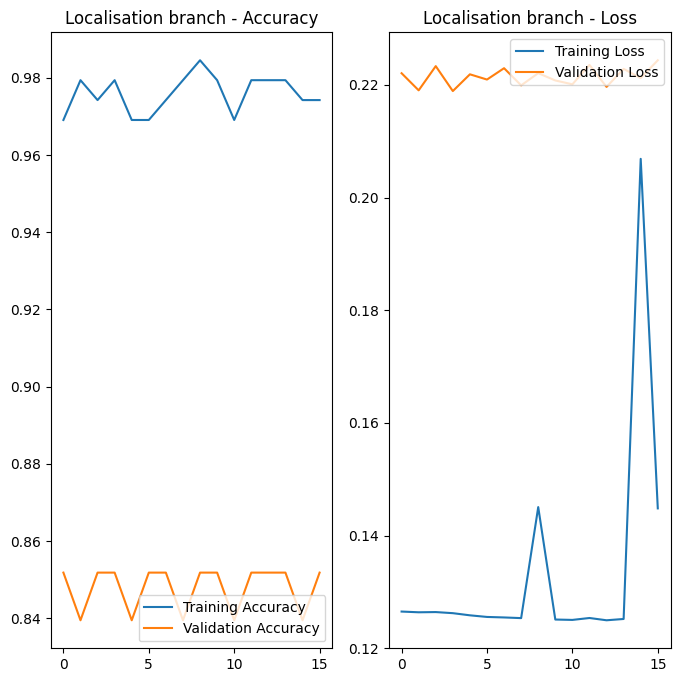

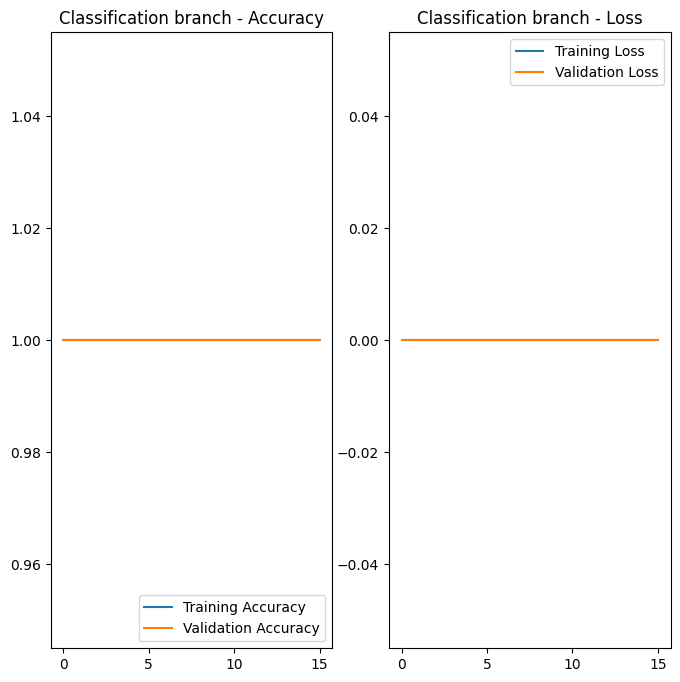

In [36]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

In [31]:
validation_images[1]

array([[[251., 251., 251.],
        [251., 251., 251.],
        [251., 251., 251.],
        ...,
        [120.,  88.,  49.],
        [120.,  88.,  49.],
        [120.,  88.,  49.]],

       [[251., 251., 251.],
        [251., 251., 251.],
        [251., 251., 251.],
        ...,
        [120.,  88.,  49.],
        [120.,  88.,  49.],
        [120.,  88.,  49.]],

       [[251., 251., 251.],
        [251., 251., 251.],
        [251., 251., 251.],
        ...,
        [114.,  82.,  43.],
        [114.,  82.,  43.],
        [114.,  82.,  43.]],

       ...,

       [[204., 162., 114.],
        [204., 162., 114.],
        [205., 163., 115.],
        ...,
        [172., 144.,  79.],
        [188., 156., 115.],
        [183., 151., 110.]],

       [[219., 177., 129.],
        [210., 168., 120.],
        [204., 162., 114.],
        ...,
        [176., 148.,  83.],
        [183., 153., 101.],
        [174., 144.,  92.]],

       [[219., 177., 129.],
        [210., 168., 120.],
        [204., 1

In [ ]:
validation_img = 'data/images/kangaroo-30.jpg'



img = keras.preprocessing.image.load_img(validation_img, target_size=(600, 600))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)

predictions = model.predict(img)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[array([[-14.082061,  16.633087]], dtype=float32),
 array([[0.25848135, 0.24368717, 0.49165964, 0.97775227]], dtype=float32)]

In [44]:
normalized_bounding_boxes = predictions[1]
normalized_bounding_boxes[9]

array([0.0000000e+00, 0.0000000e+00, 1.2980038e-35, 1.0000000e+00],
      dtype=float32)

In [45]:
normalized_bounding_boxes[2].tolist()

[0.0, 0.0, 3.7740313482020087e-31, 1.0]

In [58]:
bounding_boxes = []

for i in range(len(normalized_bounding_boxes)):
    w = test_widths[i]
    h = test_heights[i]
    xmin, ymin, xmax, ymax = normalized_bounding_boxes[i].tolist()

    x1 = round(xmin * w, 2)
    y1 = round(ymin * h, 2)
    x2 = round(xmax * w, 2)
    y2 = round(ymax * h, 2)

    bounding_boxes.append([x1, y1, x2, y2])

In [59]:
bounding_boxes

[[0.0, 0.0, 0.0, 1125.0],
 [0.0, 0.0, 0.0, 2000.0],
 [0.0, 0.0, 0.0, 712.0],
 [0.0, 0.0, 0.0, 576.0],
 [0.0, 0.0, 0.0, 900.0],
 [0.0, 0.0, 0.0, 1368.0],
 [0.0, 0.0, 0.0, 549.0],
 [0.0, 0.0, 0.0, 136.0],
 [0.0, 0.0, 0.0, 1246.0],
 [0.0, 0.0, 0.0, 183.0],
 [0.0, 0.0, 0.0, 790.0],
 [0.0, 0.0, 0.0, 1365.0],
 [0.0, 0.0, 0.0, 900.0],
 [0.0, 0.0, 0.0, 600.0],
 [0.0, 0.0, 0.0, 800.0],
 [0.0, 0.0, 0.0, 189.0],
 [0.0, 0.0, 0.0, 1440.0],
 [0.0, 0.0, 0.0, 3638.0],
 [0.0, 0.0, 0.0, 576.0],
 [0.0, 0.0, 0.0, 824.0],
 [0.0, 0.0, 0.0, 683.0],
 [0.0, 0.0, 0.0, 771.0],
 [0.0, 0.0, 0.0, 529.0],
 [0.0, 0.0, 0.0, 1791.0],
 [0.0, 0.0, 0.0, 698.0],
 [0.0, 0.0, 0.0, 610.0],
 [0.0, 0.0, 0.0, 576.0],
 [0.0, 0.0, 0.0, 698.0],
 [0.0, 0.0, 0.0, 183.0],
 [0.0, 0.0, 0.0, 168.0],
 [0.0, 0.0, 0.0, 678.0],
 [0.0, 0.0, 0.0, 174.0],
 [0.0, 0.0, 0.0, 567.0],
 [0.0, 0.0, 0.0, 900.0],
 [0.0, 0.0, 0.0, 1000.0],
 [0.0, 0.0, 0.0, 558.0],
 [0.0, 0.0, 0.0, 773.0],
 [0.0, 0.0, 0.0, 630.0],
 [0.0, 0.0, 0.0, 1600.0],
 [0.0, 0.0, 0.0

In [51]:
from PIL import Image, ImageDraw

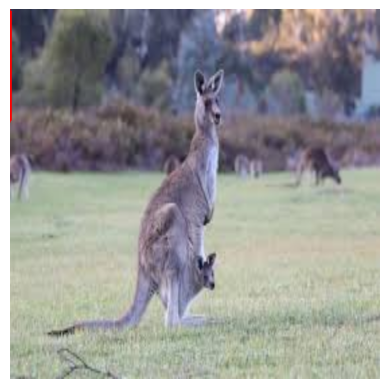

In [56]:
index = 9

bounded_image = Image.open(TEST_IMAGE_DIR + '\\' +  found_test_images[index])
bounded_image = cv2.resize(np.array(bounded_image), target_size)

bounded_image = Image.fromarray(bounded_image)

draw = ImageDraw.Draw(bounded_image)

draw.rectangle(bounding_boxes[index], outline='red', width=3)

plt.imshow(bounded_image)
plt.axis('off')
plt.show()